## Import

In [2]:
%load_ext autoreload
%autoreload 2

from typing import Optional, Union
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import sys 

sys.path.append('../../src/modules')
import eumf_data, eumf_pipeline, eumf_eval
from eumf_data import Labeled

from sklearn import preprocessing, pipeline, compose, ensemble, model_selection, metrics, impute, dummy

pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)



## Load Data

In [6]:
# list of countries
countries = eumf_data.get_countries()
countries.remove("CY")

# migration rates
df_values = eumf_data.load_registrations_from_csv(impute_missing=True, countries=countries)

# google trends
df_trends = eumf_data.load_trends_from_csv(countries=countries)
keyword_ids = df_trends.columns.levels[0].tolist()

# macroeconomic data
df_gdp = eumf_data.read_gdp(countries=countries)
df_unempl = eumf_data.read_unempl(countries=countries)

country_combinations = [
    # ["GR", "CY"],
    ["LV", "LT", "EE"],
    ["BE", "NL", "LU"],
    ["CZ", "SK"],
    ["SE", "FI", "DK"],
    ["AT", "CH"]
]

panel = df_values.join(df_trends, how="outer")
panel_3m = panel.resample("3M", closed="left").mean()

panel_comb = eumf_data.combine_countries(panel, combinations=country_combinations)
panel_comb_3m = eumf_data.combine_countries(panel_3m, combinations=country_combinations)
df_gdp_comb = eumf_data.combine_countries(df_gdp, combinations=country_combinations)
df_unempl_comb = eumf_data.combine_countries(
    df_unempl, combinations=country_combinations, average=True
)
# note: strictly, unweighted average is wrong for unemployment, but should work in most cases

panel_comb_3m_macro = panel_comb_3m.join(df_gdp_comb).join(df_unempl_comb)

panel_comb_3m_macro["2017":"2018"]



10                                                                                                                       11                                                                                                                                            112                                                                                                               ...   value                                                                                                                                     gdp                                                                                                                                                unempl                                                                                                      
country     AT+CH  BE+NL+LU  BG  CZ+SK    ES      FR      GB    GR   HR   HU   IE     IT   LV+LT+EE    PL    PT   RO  SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR     HR      HU      IE      IT   LV+LT+EE    PL      PT      RO   SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK      ES      FR      GB      GR      HR      HU      IE      IT   LV+LT+EE    PL    ...     ES        FR        GB        GR        HR        HU       IE        IT     LV+LT+EE     PL        PT        RO     SE+FI+DK    SI     AT+CH   BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR      HR      HU      IE       IT   LV+LT+EE    PL      PT      RO   SE+FI+DK    SI   AT+CH  BE+NL+LU  BG  CZ+SK   ES   FR   GB    GR    HR   HU   IE    IT  LV+LT+EE  PL   PT   RO  SE+FI+DK  SI 
date                                                                                                                                                                                                                                                                                                                                                                                                   ...                                                                                                                                                                                                                                                                                                                                                                                                            
2017-03-31  10.524  16.048   0.0   0.0  26.667  21.857  21.381  0.0  0.0  0.0  0.0  14.095    0.0     6.095  0.0  0.0  21.286   0.0  34.714  60.190    2.190  10.857  38.714  29.810  53.381  10.000  0.000   0.619  11.095  22.048    0.0    11.952  12.714  11.571  26.524   0.0  97.190  178.952  42.238  127.048  33.143  63.333  47.286   9.000  63.095  62.810  59.333  14.905  179.429  39.524  ...  1689.000  1268.333  1080.333  2327.333  4459.000  3747.667  156.000  5255.333  1396.333  12264.667  866.333  18186.333  654.333  420.333  28780.0  42970.0  1510.0  7620.0  5950.0  8450.0  9080.0  3760.0  2590.0  2820.0  14640.0  6800.0  10490.0  2760.0  4520.0  1850.0  33780.0  4790.0  2.85    6.433   6.6  6.00  18.2  9.6  4.6  22.4  12.7  4.3  7.4  11.6   7.333   5.3  9.8  5.3   7.167   7.4
2017-06-30   4.952  14.810   0.0   0.0  21.048  13.952  18.857  0.0  0.0  0.0  0.0  15.286    0.0     6.524  0.0  0.0  27.714   0.0  39.286  61.619   10.619   7.714  24.381  27.952  55.714   4.714  2.333   7.095  20.619  17.286    0.0    13.810  23.143  11.143  32.857   0.0  85.619  168.905  35.190   83.429  23.810  57.857  48.000  11.905  33.048  27.905  62.810  14.286  126.667  21.476  ...  1427.667  1023.333  1049.000  2113.333  4121.333  3637.667  164.667  4699.000  1407.000  12940.000  609.667  19264.000  520.333  365.000  29250.0  44540.0  1800.0  8470.0  6330.0  8560.0  8980.0  4120.0  2990.0  3200.0  14700.0  7140.0  11780.0  2960.0  4790.0  2200.0  35590.0  5260.0  2.70    5.867   6.2  5.75  17.3  9.6  4.4  21.8  11.5  4.3  6.7  11.3   7.667   5.1  9.2  4.9   7.133   6.6
2017-09-30   4.905  16.095   0.0   0.0  12.429  21.048  16.

## Experiments

### Multiclass variant

#### Common definitions

In [7]:
T_MIN = "2010"
T_MAX = "2019"

T_TEST_MIN = "2014"
T_TEST_MAX = "2014"

SCORING_MULTICLS = ["f1_micro", "f1_macro", "precision_macro", "recall_macro"]

cv_default = eumf_eval.BlockKFold(n_splits=8, margin=1.0)
cv_random = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
# n_countries = len(panel_comb_3m_macro["value"].columns)
# cv_time = model_selection.TimeSeriesSplit(test_size=4 * n_countries, n_splits=6)

#### Obtain optimum discretization

In [8]:
cv_scores, dummy_scores = {}, {}

lags_default = [1, 2, 3, 4, 5, 6]
alternate_lags_default = {
    "value": [3, 4, 5, 6],
    "gdp": [2, 3, 4, 5, 6],
    "unempl": [2, 3, 4, 5, 6],
}


for delta1 in [0.05, 0.1, 0.15, 0.2]:
    for delta2 in [0.0, 0.3, 0.4, 0.5]:

        if delta2 == 0.0:
            bins = [-np.inf, np.log(1.0 - delta1), np.log(1.0 + delta1), np.inf]
            classes = ["-", "=", "+"]
        else:
            bins = [
                -np.inf,
                np.log(1.0 - delta1),
                np.log(1.0 + delta1),
                np.log(1.0 + delta2),
                np.inf,
            ]
            classes = ["-", "=", "+", "++"]

        labeled = eumf_pipeline.prepare_data(
            panel_comb_3m_macro,
            columns=["19", "value", "gdp", "unempl"],
            lags=lags_default,
            alternate_lags=alternate_lags_default,
            t_min=T_MIN,
            t_max=T_MAX,
        )
        transformed = eumf_pipeline.transform_data(labeled)
        train, test = eumf_pipeline.split_data(
            transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
        )
        train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)
        train_cls, test_cls = eumf_pipeline.discretize_labels(
            train_stacked, test_stacked, bins=bins, classes=classes
        )

        tuner = eumf_pipeline.train_cls_model(train_cls)

        dummy_cls = dummy.DummyClassifier(strategy="stratified")

        cv_scores[(delta1, delta2)] = eumf_eval.score_cv(
            tuner.best_estimator_,
            train_cls,
            cv=cv_default,
            scoring=[
                "f1_micro",
                "f1_macro",
                "precision_micro",
                "precision_macro",
                "recall_micro",
                "recall_macro",
            ],
        )

        dummy_scores[(delta1, delta2)] = eumf_eval.score_cv(
            dummy_cls,
            train_cls,
            cv=cv_default,
            scoring=[
                "f1_micro",
                "f1_macro",
                "precision_micro",
                "precision_macro",
                "recall_micro",
                "recall_macro",
            ],

        )


/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stei509/anaconda3/envs/eumf/lib/python3

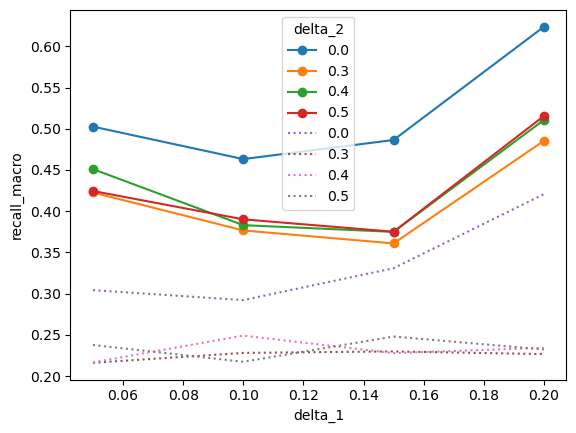

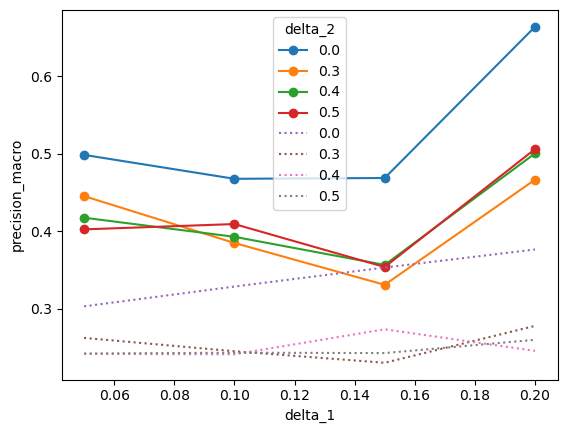

In [9]:
results = (
    pd.concat({k: v for k, v in cv_scores.items()})
    .rename_axis(index=["delta_1", "delta_2", "fold"])
    .groupby(level=[0, 1])
    .mean()
)
dummy_results = (
    pd.concat({k: v for k, v in dummy_scores.items()})
    .rename_axis(index=["delta_1", "delta_2", "fold"])
    .groupby(level=[0, 1])
    .mean()
)

results.unstack(level=1)["test_recall_macro"].plot(
    ylabel="recall_macro", ls="-", marker="o"
)
dummy_results.unstack(level=1)["test_recall_macro"].plot(
    ylabel="recall_macro", ls=":", ax=plt.gca()
)
plt.show()

results.unstack(level=1)["test_precision_macro"].plot(
    ylabel="precision_macro", ls="-", marker="o"
)
dummy_results.unstack(level=1)["test_precision_macro"].plot(
    ylabel="precision_macro", ls=":", ax=plt.gca()
)
plt.show()

# ["test_f1_macro"].plot()
# plt.show()


Despite these results, one should opt for lower thresholds. Otherwise, number of class members is too small and meaningless.

#### 4 Classes: "Best" configuration

In [26]:
"""training"""

bins = [-np.inf, np.log(0.95), np.log(1.05), np.log(1.4), np.inf]
classes = [-1,0,1,2]

params = {}

labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro,
    columns=["19", "value", "gdp", "unempl"],
    lags=lags_default,
    alternate_lags=alternate_lags_default,
    t_min=T_MIN,
    t_max=T_MAX,
)
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)
train_cls, test_cls = eumf_pipeline.discretize_labels(
    train_stacked, test_stacked, bins=bins, classes=classes
)

tuner = eumf_pipeline.train_cls_model(train_cls, params=params)

display(pd.DataFrame(tuner.cv_results_))

cv_score = eumf_eval.score_cv(
    tuner.best_estimator_, train_cls, cv=cv_default, scoring=SCORING_MULTICLS,
)

cv_score_emd = eumf_eval.score_cv(
    tuner.best_estimator_, train_cls, cv=cv_default, scoring=eumf_eval.scorer_emd,
)

test_score = eumf_eval.score_test(
    tuner.best_estimator_, test_cls, scoring=SCORING_MULTICLS,
)

print("Aggregate CV score:")
display(eumf_eval.agg_cv_scores(cv_score, use_quantiles=False))

print("CV earth movers distance:")
display(eumf_eval.agg_cv_scores(cv_score_emd, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.707,0.069,0.046,0.006,{},0.407,0.409,0.494,0.444,0.399,0.334,0.414,0.048,1


/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Aggregate CV score:


/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,mean,std,sem
fit_time,0.307,0.045,0.016
score_time,0.033,0.010,0.004
test_f1_micro,0.533,0.066,0.023
test_f1_macro,0.408,0.076,0.027
test_precision_macro,0.417,0.105,0.037
test_recall_macro,0.450,0.069,0.024


CV earth movers distance:


,mean,std,sem
fit_time,0.234,0.018,0.006
score_time,0.016,0.003,0.001
test_score,-0.293,0.148,0.052


Individual CV scores:


,fit_time,score_time,test_f1_micro,test_f1_macro,test_precision_macro,test_recall_macro
0,0.319,0.029,0.417,0.302,0.253,0.450
1,0.322,0.049,0.542,0.408,0.405,0.414
2,0.374,0.045,0.556,0.492,0.562,0.483
3,0.319,0.031,0.514,0.372,0.383,0.377
4,0.273,0.037,0.556,0.520,0.573,0.564
5,0.263,0.024,0.528,0.389,0.370,0.426
6,0.237,0.023,0.653,0.448,0.398,0.519
7,0.345,0.025,0.500,0.330,0.387,0.367


Holdout score:


f1_micro           0.472
f1_macro           0.335
precision_macro    0.415
recall_macro       0.350
dtype: float64

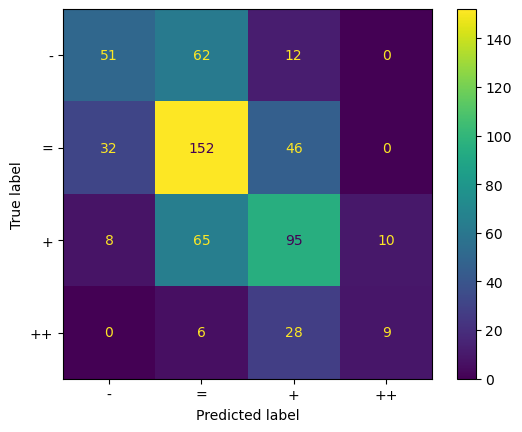

In [25]:
"""confusion matrix"""

# y predicted over cv
estimator = tuner.best_estimator_
pred_arr_cv = model_selection.cross_val_predict(
    estimator, train_cls.x, train_cls.y, cv=cv_default
)
y_pred_cv = pd.Series(pred_arr_cv, index=train_cls.x.index)

metrics.ConfusionMatrixDisplay.from_predictions(
    train_cls.y, y_pred_cv, display_labels=["-", "=", "+", "++"]
)
plt.show()


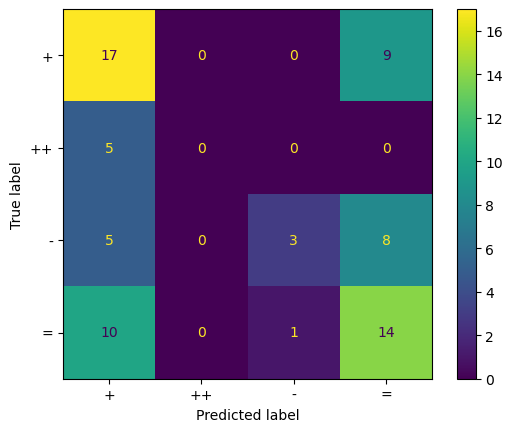

In [21]:
### CONFUSION MATRIX TEST

# y predicted over cv
estimator = tuner.best_estimator_
pred_arr_test = estimator.predict(test_cls.x)
y_pred_test = pd.Series(pred_arr_test, index=test_cls.x.index)

metrics.ConfusionMatrixDisplay.from_predictions(test_cls.y, y_pred_test)
plt.show()


#### 3 Classes: "Best" configuration

In [28]:
bins = [-np.inf, np.log(0.95), np.log(1.05), np.inf]
classes = [-1, 0, 1]

params = {}

labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro,
    columns=["19", "value", "gdp", "unempl"],
    lags=lags_default,
    alternate_lags=alternate_lags_default,
    t_min=T_MIN,
    t_max=T_MAX,
)
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)
train_cls, test_cls = eumf_pipeline.discretize_labels(
    train_stacked, test_stacked, bins=bins, classes=classes
)

tuner = eumf_pipeline.train_cls_model(train_cls, params=params)

display(pd.DataFrame(tuner.cv_results_))

cv_score = eumf_eval.score_cv(
    tuner.best_estimator_, train_cls, cv=cv_default, scoring=SCORING_MULTICLS,
)

cv_score_emd = eumf_eval.score_cv(
    tuner.best_estimator_, train_cls, cv=cv_default, scoring=eumf_eval.scorer_emd,
)

test_score = eumf_eval.score_test(
    tuner.best_estimator_, test_cls, scoring=SCORING_MULTICLS,
)

print("Aggregate CV score:")
display(eumf_eval.agg_cv_scores(cv_score, use_quantiles=False))

print("CV earth movers distance:")
display(eumf_eval.agg_cv_scores(cv_score_emd, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.658,0.172,0.055,0.018,{},0.716,0.444,0.653,0.458,0.383,0.3,0.492,0.146,1


/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Aggregate CV score:


,mean,std,sem
fit_time,0.288,0.055,0.019
score_time,0.029,0.003,0.001
test_f1_micro,0.592,0.099,0.035
test_f1_macro,0.458,0.107,0.038
test_precision_macro,0.480,0.137,0.049
test_recall_macro,0.495,0.120,0.042


CV earth movers distance:


,mean,std,sem
fit_time,0.231,0.035,0.012
score_time,0.017,0.003,0.001
test_score,-0.247,0.085,0.030


Individual CV scores:


,fit_time,score_time,test_f1_micro,test_f1_macro,test_precision_macro,test_recall_macro
0,0.362,0.028,0.736,0.609,0.610,0.742
1,0.266,0.026,0.708,0.427,0.414,0.442
2,0.233,0.033,0.639,0.589,0.701,0.561
3,0.256,0.031,0.542,0.518,0.533,0.528
4,0.274,0.030,0.514,0.448,0.547,0.479
5,0.244,0.023,0.486,0.360,0.348,0.394
6,0.382,0.031,0.625,0.400,0.358,0.458
7,0.285,0.028,0.486,0.309,0.332,0.355


Holdout score:


f1_micro           0.556
f1_macro           0.506
precision_macro    0.617
recall_macro       0.501
dtype: float64

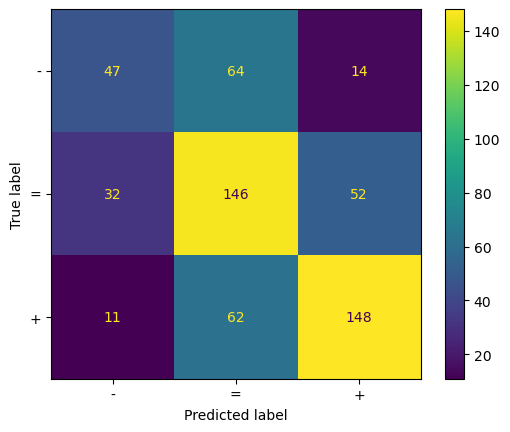

In [30]:
# y predicted over cv
estimator = tuner.best_estimator_
pred_arr_cv = model_selection.cross_val_predict(
    estimator, train_cls.x, train_cls.y, cv=cv_default
)
y_pred_cv = pd.Series(pred_arr_cv, index=train_cls.x.index)

metrics.ConfusionMatrixDisplay.from_predictions(train_cls.y, y_pred_cv, display_labels=["-","=","+"])
plt.show()


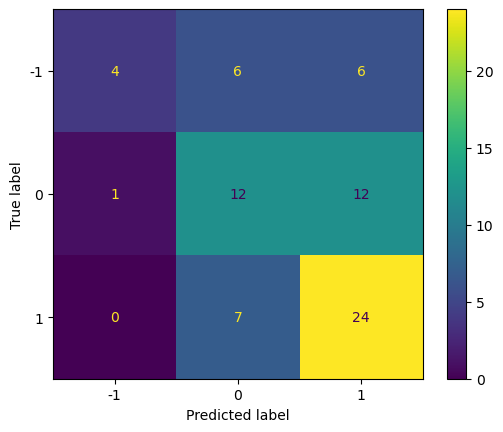

In [31]:
### CONFUSION MATRIX TEST

# y predicted over cv
estimator = tuner.best_estimator_
pred_arr_test = estimator.predict(test_cls.x)
y_pred_test = pd.Series(pred_arr_test, index=test_cls.x.index)

metrics.ConfusionMatrixDisplay.from_predictions(test_cls.y, y_pred_test)
plt.show()


#### 3 Classes: best configuration, but without own lags

In [32]:
bins = [-np.inf, np.log(0.95), np.log(1.05), np.inf]
classes = [-1,0,1]

params = {}

labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro,
    columns=["19", "gdp", "unempl"],
    lags=lags_default,
    alternate_lags=alternate_lags_default,
    t_min=T_MIN,
    t_max=T_MAX,
)
transformed = eumf_pipeline.transform_data(labeled)
train, test = eumf_pipeline.split_data(
    transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
)
train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)
train_cls, test_cls = eumf_pipeline.discretize_labels(
    train_stacked, test_stacked, bins=bins, classes=classes
)

tuner = eumf_pipeline.train_cls_model(train_cls, params=params)

display(pd.DataFrame(tuner.cv_results_))

cv_score = eumf_eval.score_cv(
    tuner.best_estimator_, train_cls, cv=cv_default, scoring=SCORING_MULTICLS,
)

test_score = eumf_eval.score_test(
    tuner.best_estimator_, test_cls, scoring=SCORING_MULTICLS,
)

print("Aggregate CV score:")
display(eumf_eval.agg_cv_scores(cv_score, use_quantiles=False))

print("Individual CV scores:")
display(cv_score)

print("Holdout score:")
display(test_score)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.655,0.021,0.062,0.018,{},0.682,0.357,0.642,0.458,0.407,0.395,0.49,0.125,1


/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Aggregate CV score:


,mean,std,sem
fit_time,0.262,0.046,0.016
score_time,0.040,0.037,0.013
test_f1_micro,0.561,0.093,0.033
test_f1_macro,0.444,0.082,0.029
test_precision_macro,0.478,0.104,0.037
test_recall_macro,0.471,0.112,0.039


Individual CV scores:


,fit_time,score_time,test_f1_micro,test_f1_macro,test_precision_macro,test_recall_macro
0,0.329,0.029,0.736,0.590,0.590,0.688
1,0.237,0.026,0.653,0.386,0.373,0.402
2,0.220,0.033,0.528,0.439,0.616,0.411
3,0.309,0.024,0.528,0.487,0.506,0.481
4,0.233,0.025,0.542,0.519,0.564,0.579
5,0.213,0.026,0.431,0.355,0.354,0.360
6,0.245,0.025,0.556,0.410,0.421,0.463
7,0.309,0.130,0.514,0.364,0.399,0.383


Holdout score:


f1_micro           0.583
f1_macro           0.548
precision_macro    0.649
recall_macro       0.536
dtype: float64

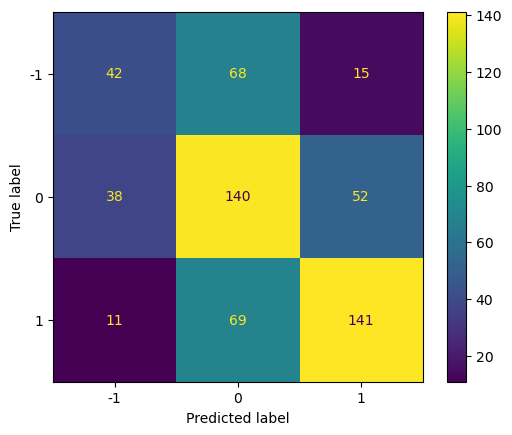

In [33]:
# y predicted over cv
estimator = tuner.best_estimator_
pred_arr_cv = model_selection.cross_val_predict(
    estimator, train_cls.x, train_cls.y, cv=cv_default
)
y_pred_cv = pd.Series(pred_arr_cv, index=train_cls.x.index)

metrics.ConfusionMatrixDisplay.from_predictions(train_cls.y, y_pred_cv)
plt.show()


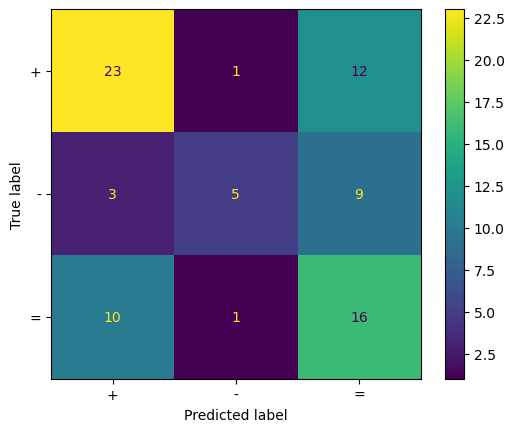

In [ ]:
### CONFUSION MATRIX TEST

# y predicted over cv
estimator = tuner.best_estimator_
pred_arr_test = estimator.predict(test_cls.x)
y_pred_test = pd.Series(pred_arr_test, index=test_cls.x.index)

metrics.ConfusionMatrixDisplay.from_predictions(test_cls.y, y_pred_test)
plt.show()
